# How to stream LLM tokens (without LangChain models)

In this guide, we will stream tokens from the language model powering an agent without using LangChain chat models. We'll be using the OpenAI client library directly in a ReAct agent as an example.

## Setup

To get started, install the `openai` and `langgraph` packages separately:

```bash
$ npm install openai @langchain/langgraph @langchain/core
```

<div class="admonition tip">
    <p class="admonition-title">Compatibility</p>
    <p>
        This guide requires <code>@langchain/core>=0.2.19</code>, and if you are using LangSmith, <code>langsmith>=0.1.39</code>. For help upgrading, see <a href="/langgraphjs/how-tos/manage-ecosystem-dependencies/">this guide</a>.
    </p>
</div>

You'll also need to make sure you have your OpenAI key set as `process.env.OPENAI_API_KEY`.

## Defining a model and a tool schema

First, initialize the OpenAI SDK and define a tool schema for the model to populate using [OpenAI's format](https://platform.openai.com/docs/api-reference/chat/create#chat-create-tools):

In [1]:
import OpenAI from "openai";

const openaiClient = new OpenAI({});

const toolSchema: OpenAI.ChatCompletionTool = {
  type: "function",
  function: {
    name: "get_items",
    description: "Use this tool to look up which items are in the given place.",
    parameters: {
      type: "object",
      properties: {
        place: {
          type: "string",
        },
      },
      required: ["place"],
    }
  }
};

## Calling the model

Now, define a method for a LangGraph node that will call the model. It will handle formatting tool calls to and from the model, as well as streaming via [custom callback events](https://js.langchain.com/docs/how_to/callbacks_custom_events).

If you are using [LangSmith](https://docs.smith.langchain.com/), you can also wrap the OpenAI client for the same nice tracing you'd get with a LangChain chat model.

Here's what that looks like:

In [2]:
import { dispatchCustomEvent } from "@langchain/core/callbacks/dispatch";
import { wrapOpenAI } from "langsmith/wrappers/openai";
import { Annotation } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  messages: Annotation<OpenAI.ChatCompletionMessageParam[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

// If using LangSmith, use "wrapOpenAI" on the whole client or
// "traceable" to wrap a single method for nicer tracing:
// https://docs.smith.langchain.com/how_to_guides/tracing/annotate_code
const wrappedClient = wrapOpenAI(openaiClient);

const callModel = async (state: typeof StateAnnotation.State) => {
  const { messages } = state;
  const stream = await wrappedClient.chat.completions.create({
    messages,
    model: "gpt-4o-mini",
    tools: [toolSchema],
    stream: true,
  });
  let responseContent = "";
  let role: string = "assistant";
  let toolCallId: string | undefined;
  let toolCallName: string | undefined;
  let toolCallArgs = "";
  for await (const chunk of stream) {
    const delta = chunk.choices[0].delta;
    if (delta.role !== undefined) {
      role = delta.role;
    }
    if (delta.content) {
      responseContent += delta.content;
      await dispatchCustomEvent("streamed_token", {
        content: delta.content,
      });
    }
    if (delta.tool_calls !== undefined && delta.tool_calls.length > 0) {
      // note: for simplicity we're only handling a single tool call here
      const toolCall = delta.tool_calls[0];
      if (toolCall.function?.name !== undefined) {
        toolCallName = toolCall.function.name;
      }
      if (toolCall.id !== undefined) {
        toolCallId = toolCall.id;
      }
      await dispatchCustomEvent("streamed_tool_call_chunk", toolCall);
      toolCallArgs += toolCall.function?.arguments ?? "";
    }
  }
  let finalToolCalls;
  if (toolCallName !== undefined && toolCallId !== undefined) {
    finalToolCalls = [{
      id: toolCallId,
      function: {
        name: toolCallName,
        arguments: toolCallArgs
      },
      type: "function" as const,
    }];
  }

  const responseMessage = {
    role: role as any,
    content: responseContent,
    tool_calls: finalToolCalls,
  };
  return { messages: [responseMessage] };
}

Note that you can't call this method outside of a LangGraph node since `dispatchCustomEvent` will fail if it is called outside the proper context.

## Define tools and a tool-calling node

Next, set up the actual tool function and the node that will call it when the model populates a tool call:

In [3]:
const getItems = async ({ place }: { place: string }) => {
  if (place.toLowerCase().includes("bed")) {  // For under the bed
    return "socks, shoes and dust bunnies";
  } else if (place.toLowerCase().includes("shelf")) {  // For 'shelf'
    return "books, pencils and pictures";
  } else {  // if the agent decides to ask about a different place
    return "cat snacks";
  }
};

const callTools = async (state: typeof StateAnnotation.State) => {
  const { messages } = state;
  const mostRecentMessage = messages[messages.length - 1];
  const toolCalls = (mostRecentMessage as OpenAI.ChatCompletionAssistantMessageParam).tool_calls;
  if (toolCalls === undefined || toolCalls.length === 0) {
    throw new Error("No tool calls passed to node.");
  }
  const toolNameMap = {
    get_items: getItems,
  };
  const functionName = toolCalls[0].function.name;
  const functionArguments = JSON.parse(toolCalls[0].function.arguments);
  const response = await toolNameMap[functionName](functionArguments);
  const toolMessage = {
    tool_call_id: toolCalls[0].id,
    role: "tool" as const,
    name: functionName,
    content: response,
  }
  return { messages: [toolMessage] };
}

## Build the graph

Finally, it's time to build your graph:

In [4]:
import { StateGraph } from "@langchain/langgraph";
import OpenAI from "openai";

// We can reuse the same `GraphState` from above as it has not changed.
const shouldContinue = (state: typeof StateAnnotation.State) => {
  const { messages } = state;
  const lastMessage =
    messages[messages.length - 1] as OpenAI.ChatCompletionAssistantMessageParam;
  if (lastMessage?.tool_calls !== undefined && lastMessage?.tool_calls.length > 0) {
    return "tools";
  }
  return "__end__";
}

const graph = new StateGraph(StateAnnotation)
  .addNode("model", callModel)
  .addNode("tools", callTools)
  .addEdge("__start__", "model")
  .addConditionalEdges("model", shouldContinue, {
    tools: "tools",
    __end__: "__end__",
  })
  .addEdge("tools", "model")
  .compile();
  

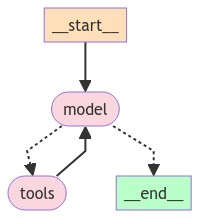

In [5]:
import * as tslab from "tslab";

const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Streaming tokens

And now we can use the [`.streamEvents`](https://js.langchain.com/docs/how_to/streaming#using-stream-events) method to get the streamed tokens and tool calls from the OpenAI model:

In [6]:
const eventStream = await graph.streamEvents(
  { messages: [{ role: "user", content: "what's in the bedroom?" }] },
  { version: "v2" },
);

for await (const { event, name, data } of eventStream) {
  if (event === "on_custom_event") {
    console.log(name, data);
  }
}

streamed_tool_call_chunk {
  index: 0,
  id: 'call_v99reml4gZvvUypPgOpLgxM2',
  type: 'function',
  function: { name: 'get_items', arguments: '' }
}
streamed_tool_call_chunk { index: 0, function: { arguments: '{"' } }
streamed_tool_call_chunk { index: 0, function: { arguments: 'place' } }
streamed_tool_call_chunk { index: 0, function: { arguments: '":"' } }
streamed_tool_call_chunk { index: 0, function: { arguments: 'bed' } }
streamed_tool_call_chunk { index: 0, function: { arguments: 'room' } }
streamed_tool_call_chunk { index: 0, function: { arguments: '"}' } }
streamed_token { content: 'In' }
streamed_token { content: ' the' }
streamed_token { content: ' bedroom' }
streamed_token { content: ',' }
streamed_token { content: ' you' }
streamed_token { content: ' can' }
streamed_token { content: ' find' }
streamed_token { content: ' socks' }
streamed_token { content: ',' }
streamed_token { content: ' shoes' }
streamed_token { content: ',' }
streamed_token { content: ' and' }
streamed_tok

And if you've set up LangSmith tracing, you'll also see [a trace like this one](https://smith.langchain.com/public/ddb1af36-ebe5-4ba6-9a57-87a296dc801f/r).